## Rebit state tomography 

Let's apply operational tomography to the task of reconstructing the state of a rebit, i.e. a qubit with no $y$ component in its Bloch vector. 

_**Note**: we have provided saved data for the version of these experiments presented in the paper. Cells are available below to both save anything new you might run, as well as to load up our version of the data for examination and plotting._ 

On our button box, we have
- two SPAM buttons, one to prepare the rebit state, the other to measure $|0\rangle \langle 0|$
- two gate buttons that we are *pretty* sure perform $R_x(\frac{\pi}{2}), R_y(\frac{\pi}{2})$

We choose as our fiducials the set $\{\cdot, \quad R_x(\frac{\pi}{2}), \quad R_y(\frac{\pi}{2}), \quad R_x(\frac{\pi}{2}) R_x(\frac{\pi}{2})\}$ as this gives us something informationally complete for a single qubit in principle - assuming our $R_x$ and $R_y$ button do what we think they do, this set of fiducials will provide us with measurements along the three axes of the Bloch sphere.

We will set up a prior distribution over the model parameters like so:
- $\rho$ will be sampled from the Ginibre distribution over rebits
- The rotations will be chosen over angles $\frac{\pi}{2} \pm \varepsilon$, where $\varepsilon$ is some small parameter chosen from a normal distribution
- $E$ will be $|0\rangle \langle 0|$
- all buttons are then independently depolarized with $p$ chosen uniformly from the range $[0, 0.1]$

Import the things we need:

In [1]:
#%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'dpi': 300}
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append("../src/")

import numpy as np
np.set_printoptions(suppress = True, precision = 6)

import qinfer as qi
import qutip as qutip

from tqdm import tqdm

import oqt
from oqt.heuristics import QSTHeuristic
from oqt.gates import GSeq
from oqt.distributions import *
from oqt.errors import DepolarizingChannel

## Set up the parameterization and the prior

As described above.

In [2]:
param = oqt.linear_parameterization.GatesetParameterization(
    gateset_labels=['rot_x', 'rot_y'], 
    fiducial_labels=[[], ['rot_x'], ['rot_y'], ['rot_x', 'rot_x']])

model = qi.BinomialModel(oqt.linear_parameterization.GatesetModel(param))

In [3]:
# A depolarizing channel error; we will apply this to everything
depolarizer = DepolarizingChannel(p=qi.UniformDistribution(ranges=(0, 0.1)))

# Set up over-rotated priors for Bloch rotation
var = 1e-3
x_prior = BlochRotationDistribution(axis = 'x', theta = qi.NormalDistribution(np.pi/2, var),
                                    channel_error=depolarizer)
y_prior = BlochRotationDistribution(axis = 'y', theta = qi.NormalDistribution(np.pi/2, var),
                                    channel_error=depolarizer)

# Priors for SPAM
ρ_prior = OQTRebitDistribution(dim=2, channel_error=depolarizer)

ideal_E = np.array([1, 0, 0, 1]) / np.sqrt(2) # measuring |0><0| also, software will perform prob(1) = 1 - prob(0)
E_prior = ConstantStateDistribution(ideal_E, channel_error=depolarizer)

SPAM_prior = CombinedSPAMDistribution(ρ_prior, E_prior)

# Put everything together
unknown_operators = {
                     'rot_x' : x_prior,
                     'rot_y' : y_prior,
                     'WellKnownGates.SPAM' : SPAM_prior
                    }
prior = oqt.distributions.GSTProductDistribution(param, unknown_operators=unknown_operators)

## Generate random rebit states

We will perform QST in the OQT formalism on 500 rebit states pulled from the prior. For each rebit state we will sample a new noisy version of the accompanying rotation/measurement operations. We'll store the true versions of all these model parameters for later comparison with what we reconstruct.

In [4]:
n_states = 1000

true_rot_x = x_prior.sample(n_states)
true_rot_y = y_prior.sample(n_states)

true_states = ρ_prior.sample(n_states)
true_meas = E_prior.sample(n_states)

true_spam_supops = np.einsum("ijk,ilk->ijl", true_states, true_meas)

true_gs_tensors = np.empty((n_states), param.gs_tensor_dtype)
true_gs_tensors['rot_x'] = true_rot_x
true_gs_tensors['rot_y'] = true_rot_y

true_gs_tensors[str(oqt.gates.WellKnownGates.SPAM)] = true_spam_supops

true_modelparams = param.gs_tensor_to_modelparams(true_gs_tensors)

## Perform OQT

We will perform 50 experiments, where each experiment is sequence of $n$ fiducials selected uniformly at random, where $n$ increases linearly from 1 to 10 over the course of the training.

In [5]:
n_particles = 10000
n_experiments = 50

bloch_vectors_naive = np.zeros((n_states, 3))
bloch_vectors_naive_reconstructed = np.zeros((n_states, 3))

updater = qi.SMCUpdater(model, n_particles, prior) 

for state_idx in tqdm(range(n_states)):
    # Collect the true Bloch vector from the operational representation
    true_params = true_modelparams[state_idx].reshape((1, param.n_modelparams)) # Get a set of parameters
    bloch_vectors_naive[state_idx, 0] = 2*true_params[0][2] - 1
    bloch_vectors_naive[state_idx, 1] = 2*true_params[0][1] - 1
    bloch_vectors_naive[state_idx, 2] = 2*true_params[0][0] - 1

    # Construct the 
    heuristic = QSTHeuristic(updater, n_experiments, param.fiducial_labels, max_germs = 10)

    # Perform OQT and do the updates
    for idx_experiment in range(n_experiments):
        experiment = heuristic()
        datum = model.simulate_experiment(true_params, experiment) # TODO

        with qi.perf_testing.numpy_err_policy(invalid='raise'):
            updater.update(datum, experiment)

    # Compute the distance
    reconstructed_params = updater.est_mean()
    
    # Compute the 'new' Bloch vector    
    bloch_vectors_naive_reconstructed[state_idx, 0] = 2*reconstructed_params[2] - 1
    bloch_vectors_naive_reconstructed[state_idx, 1] = 2*reconstructed_params[1] - 1
    bloch_vectors_naive_reconstructed[state_idx, 2] = 2*reconstructed_params[0] - 1

    updater.reset()

100%|██████████| 1000/1000 [1:37:38<00:00,  5.86s/it]


Save or load the data files as desired.

In [6]:
prefix = '2020-08-19-rebit-bloch-1000'
np.savez(prefix + 'recon_naive.npz', vectors=bloch_vectors_naive_reconstructed)
np.savez(prefix + 'naive.npz', vectors=bloch_vectors_naive)
np.savez(prefix + 'true.npz', vectors=true_states)

## Analysis

In [ ]:
# Uncomment to load the data from our provided files
true_states = np.load("../data/rebit_qst/2020-08-19-rebit-bloch-1000true.npz")['vectors']
bloch_vectors_naive = np.load("../data/rebit_qst/2020-08-19-rebit-bloch-1000naive.npz")['vectors']
bloch_vectors_naive_reconstructed = np.load("../data/rebit_qst/2020-08-19-rebit-bloch-1000recon_naive.npz")['vectors']
n_states = true_states.shape[0]

In [7]:
# Plotting helper function
def temp_rebit_plot(modelparams, distances, clim, ax, rebit_axes=[1, 3]):
    if ax == None:
        ax = plt.gca()
    mps = modelparams[:, rebit_axes] * np.sqrt(2)
    t = ax.scatter(mps[:, 0], mps[:, 1], c=distances, s=2, vmin=clim[0], vmax=clim[1])
    ax.add_artist(plt.Circle((0, 0), 1, color='k', fill=False))
    return ax, t

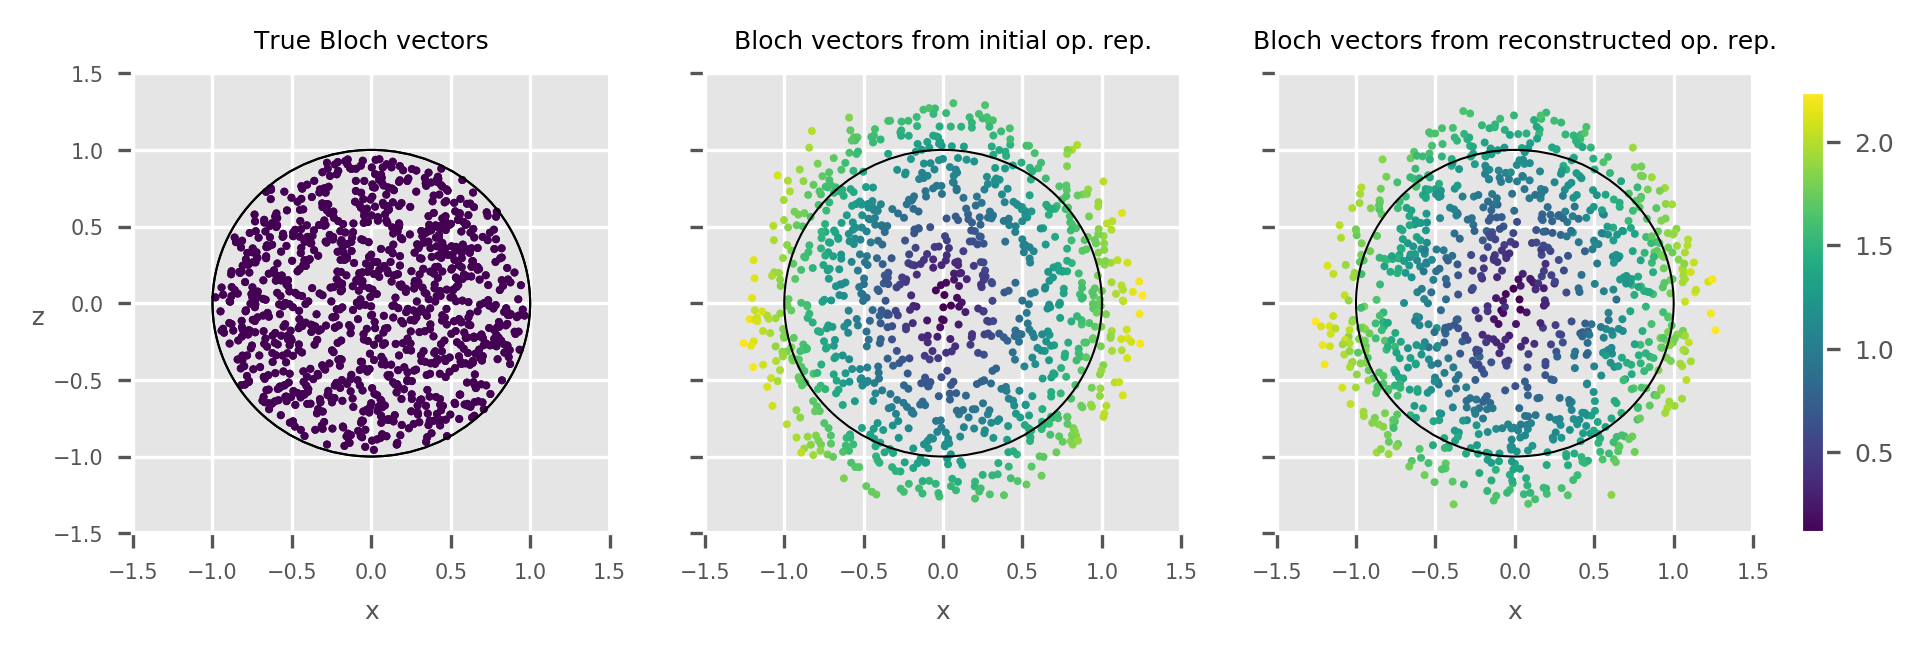

In [8]:
# 3-panel plot coloured by distance from original true states
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(8,2.1))

# Compute distances between the op. rep. pseudo-Bloch vectors from the true Bloch vectors 
distances_oprep_from_true = np.array([np.linalg.norm(bloch_vectors_naive[i,:] - true_states[i,1:]) for i in range(n_states)])
distances_recon_oprep_from_true = np.array([np.linalg.norm(bloch_vectors_naive_reconstructed[i,:] - true_states[i,1:]) for i in range(n_states)])

# Normalize colour scheme between two plots
clim_lower = np.min(np.concatenate((distances_recon_oprep_from_true, distances_recon_oprep_from_true)))
clim_upper = np.max(np.concatenate((distances_recon_oprep_from_true, distances_recon_oprep_from_true)))
clim = (clim_lower, clim_upper)

temp_rebit_plot(true_states.reshape(n_states, 4), np.zeros(n_states).astype(int), clim, axes[0])
temp_rebit_plot(np.concatenate((np.ones((n_states, 1)) / np.sqrt(2), bloch_vectors_naive), axis=1), distances_oprep_from_true, clim, axes[1])
temp_rebit_plot(np.concatenate((np.ones((n_states, 1)) / np.sqrt(2), bloch_vectors_naive_reconstructed), axis=1), distances_recon_oprep_from_true, clim, axes[2])

axes[0].set_title('True Bloch vectors', size=6)
axes[1].set_title('Bloch vectors from initial op. rep.', size=6)
axes[2].set_title('Bloch vectors from reconstructed op. rep.', size=6)

axes[0].set_ylabel('z', size=6, rotation=180)
for ax in axes:
    ax.tick_params(labelsize=5)
    ax.set_xlabel('x', size=6)
    ax.set_xlim([-1.5, 1.5])
    ax.set_ylim([-1.5, 1.5])
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.01, 0.7])
cbar_ax.tick_params(labelsize=6)
fig.colorbar(temp_rebit_plot(true_states.reshape(n_states, 4), [0]*n_states, clim, axes[0])[1], cax=cbar_ax)

plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig("pseudo_rebits.pdf", bbox_inches="tight")

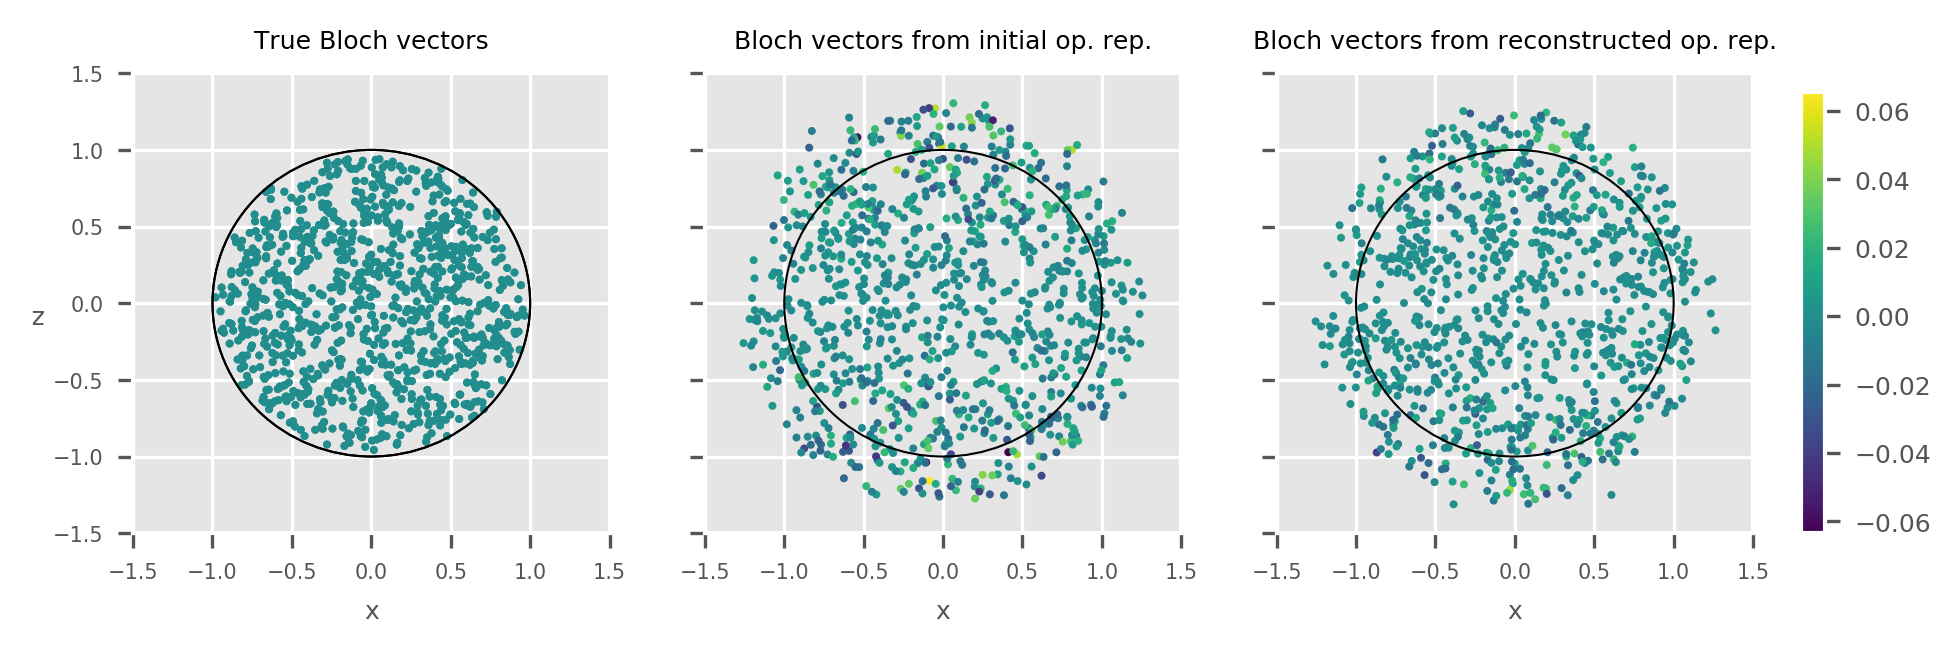

In [9]:
## 3-panel plot coloured by additional y-component picked up after tomography
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(8,2.1))

y_blur_perfect = true_states[:, 2]
y_blur_perfect_naive = bloch_vectors_naive[:, 1]
y_blur_recon_naive = bloch_vectors_naive_reconstructed[:, 1]

# Normalize colour scheme between two plots
clim_lower = np.min(np.concatenate((y_blur_perfect_naive, y_blur_recon_naive)))
clim_upper = np.max(np.concatenate((y_blur_perfect_naive, y_blur_recon_naive)))
clim = (clim_lower, clim_upper)

temp_rebit_plot(true_states, y_blur_perfect, clim, axes[0])
temp_rebit_plot(np.concatenate((np.ones((n_states, 1)) / np.sqrt(2), bloch_vectors_naive), axis=1), y_blur_perfect_naive, clim, axes[1])
temp_rebit_plot(np.concatenate((np.ones((n_states, 1)) / np.sqrt(2), bloch_vectors_naive_reconstructed), axis=1), y_blur_recon_naive, clim, axes[2])

axes[0].set_title('True Bloch vectors', size=6)
axes[1].set_title('Bloch vectors from initial op. rep.', size=6)
axes[2].set_title('Bloch vectors from reconstructed op. rep.', size=6)
axes[0].set_ylabel('z', size=6, rotation=180)
for ax in axes:
    ax.tick_params(labelsize=5)
    ax.set_xlabel('x', size=6)
    ax.set_xlim([-1.5, 1.5])
    ax.set_ylim([-1.5, 1.5])
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.01, 0.7])
cbar_ax.tick_params(labelsize=6)
fig.colorbar(temp_rebit_plot(true_states, y_blur_perfect, clim, axes[0])[1], cax=cbar_ax)

plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig("pseudo_rebits_ycolour.pdf", bbox_inches="tight")

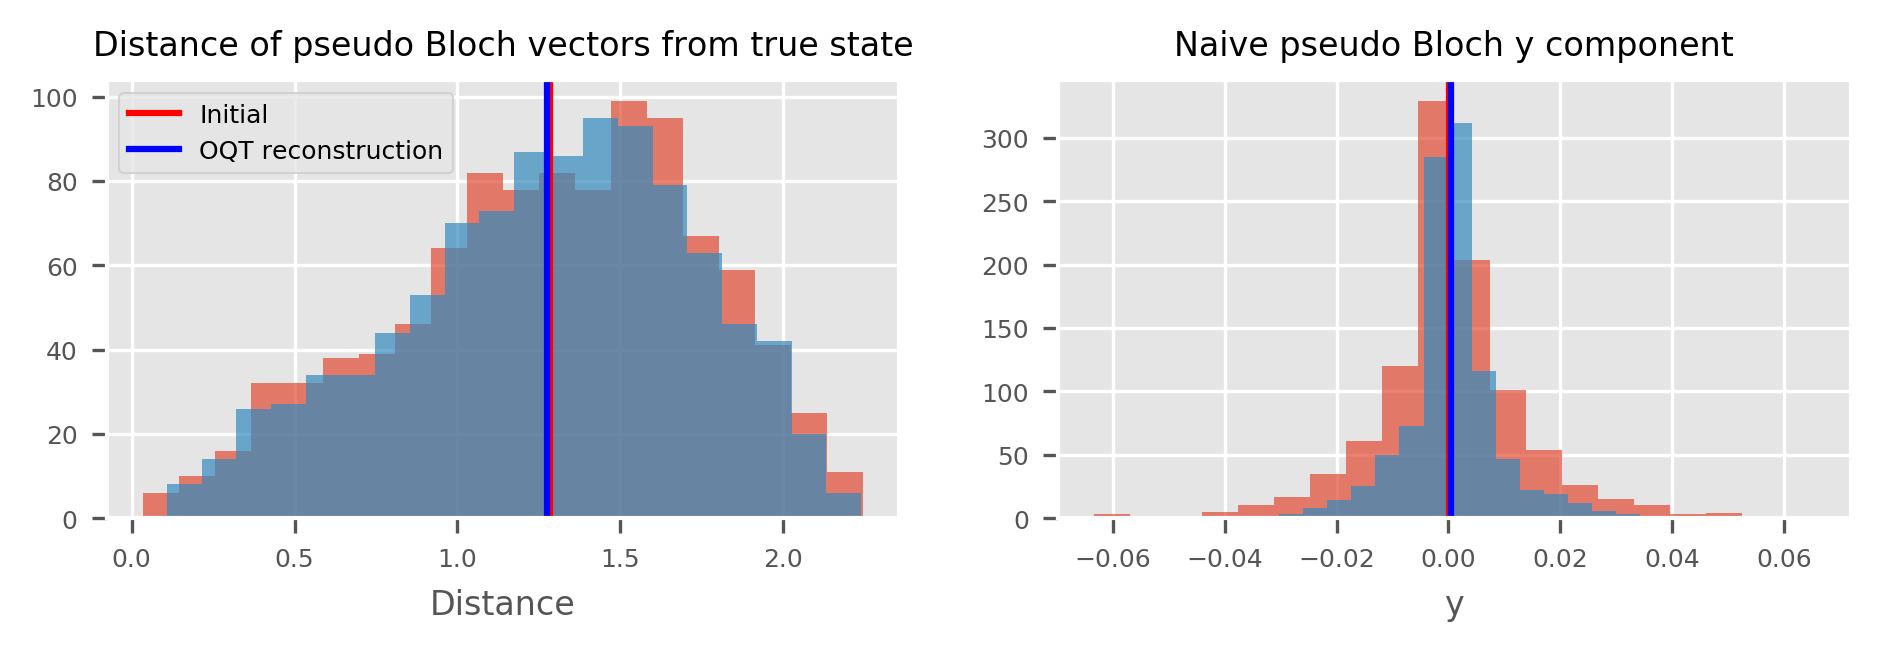

In [10]:
# Histograms of the above data
fig, axes = plt.subplots(1, 2, sharex=False, figsize=(7.5,2))

axes[0].hist(distances_oprep_from_true, alpha=0.7, bins=20)
axes[0].hist(distances_recon_oprep_from_true, alpha=0.7, bins=20)
axes[0].axvline(x=np.mean(distances_oprep_from_true), color='r')
axes[0].axvline(x=np.mean(distances_recon_oprep_from_true), color='b')
axes[0].legend(['Initial', 'OQT reconstruction'], fontsize=6)
axes[0].set_xlabel('Distance', size=8)
axes[0].tick_params(labelsize=6)
axes[0].set_title('Distance of pseudo Bloch vectors from true state', size=8)

axes[1].hist(y_blur_perfect_naive, alpha=0.7, bins=20)
axes[1].hist(y_blur_recon_naive, alpha=0.7, bins=20)
axes[1].axvline(x=np.mean(y_blur_perfect_naive), color='r')
axes[1].axvline(x=np.mean(y_blur_recon_naive), color='b')
axes[1].set_xlabel('y', size=8)
axes[1].tick_params(labelsize=6)
axes[1].set_title('Naive pseudo Bloch y component', size=8)

plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig("naive_pseudovector_comparison.pdf", bbox_inches="tight")